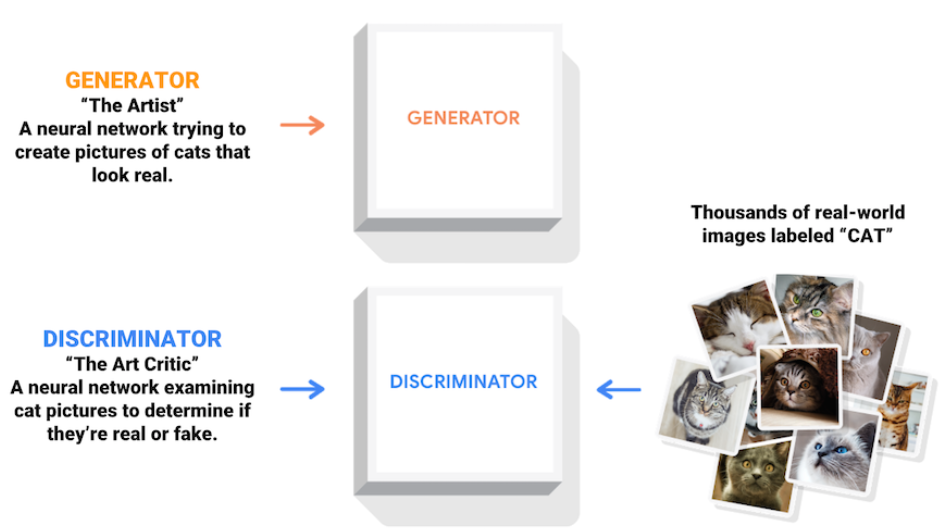

In [3]:
import tensorflow as tf
tf.__version__

'2.17.0'

In [4]:
!pip install imageio

In [5]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-usi7sm3i
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-usi7sm3i
  Resolved https://github.com/tensorflow/docs to commit 6fd6b5cc2cdd8a63156846db7064f54abc5245ce
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2024.7.15.51478-py3-none-any.whl size=182586 sha256=de671a693aa616c6bf07fd708145bdcae1040af8a32dd5570f50392abe717a52
  Stored in directory: /tmp/pip-ephem-wheel-cache-wxcg206a/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


In [6]:
import glob
import imageio
import matplotlib.pyplot as plt
import os
import numpy as np
import PIL
from tensorflow.keras import layers
import time
from IPython import display

In [7]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]
BUFFER_SIZE = 60000
BATCH_SIZE = 256
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


**Why Shuffle:** Shuffling is crucial to ensure that the model does not learn any order-based biases from the training data. It helps improve the generalization of the model by presenting the training examples in a different order for each epoch.

The generator uses **tf.keras.layers.Conv2DTranspose (upsampling)** layers to produce an image from a seed (random noise).

# The GENERATOR

In [11]:
def build_generator():
  model=tf.keras.Sequential()
  #start with noise inputted to a Dense layer
  model.add(layers.Dense(7*7*256,use_bias=False,input_shape=(100,))) #input_shape=(100,)-->random noise
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  model.add(layers.Reshape((7,7,256))) #so initial noise image has this shape
  assert model.output_shape==(None,7,7,256)
  #upsample several times until reaching the size 28*28*1
  #upsample1
  model.add(layers.Conv2DTranspose(128,(5,5),strides=(1,1),padding='same',use_bias=False))
  assert model.output_shape == (None, 7, 7, 128)

  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  #upsample2
  model.add(layers.Conv2DTranspose(64,(5,5),strides=(2,2),padding='same',use_bias=False))
  assert model.output_shape == (None, 14, 14, 64)

  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  #upsample3
  model.add(layers.Conv2DTranspose(1,(5,5),strides=(2,2),padding='same',use_bias=False))
  assert model.output_shape == (None, 28, 28, 1)

  return model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


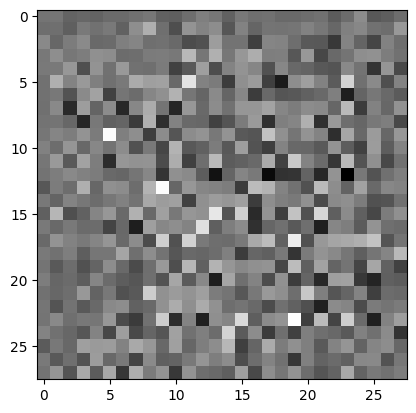

In [12]:
generator = build_generator()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, :], cmap='gray')

# The DISCRIMINATOR

The discriminator is a CNN-based image classifier.

In [25]:
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [28]:
discriminator=build_discriminator()

# Define loss & optimizers

In [16]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

**Generator loss** :
1. It quantifies **how well it was able to trick the discriminator** .
2. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1)--> compare the discriminator's output (fake_output) to an array of 1s.

In [31]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output),fake_output)

**Generator optimizer**

In [17]:
generator_optimizer=tf.keras.optimizers.Adam(1e-4)

**Discriminator loss**
1. It quantifies how well the discriminator is able to distinguish real images from fakes.
2. It compares the discriminator's predictions on **real** images to an array of **1s**, and the discriminator's predictions on **fake** (**generated**) images to an array of **0s**.

In [20]:
def discriminator_loss(real_output,fake_output):
  real_loss=cross_entropy(tf.ones_like(real_output),real_output)
  fake_loss=cross_entropy(tf.zeros_like(fake_output),fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

**Discriminator optimizer**

In [18]:
discriminator_optimizer=tf.keras.optimizers.Adam(1e-4)

# Training

In [29]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [30]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

**tf.GradientTape():** The context manager that records operations for automatic differentiation.

In [37]:
@tf.function #to compile the fct
def train_step(images):
   noise=tf.random.normal([BATCH_SIZE,noise_dim])
   with tf.GradientTape() as gen_tape,tf.GradientTape() as discr_tape:
    real_output=discriminator(images,training=True)
    generated_images=generator(noise,training=True)
    fake_output=discriminator(generated_images,training=True)
    gen_loss=generator_loss(fake_output)
    discr_loss=discriminator_loss(real_output,fake_output)

    gen_gradients=gen_tape.gradient(gen_loss,generator.trainable_variables)
    discr_gradients=discr_tape.gradient(discr_loss,discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gen_gradients,generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discr_gradients, discriminator.trainable_variables))

In [34]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [35]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

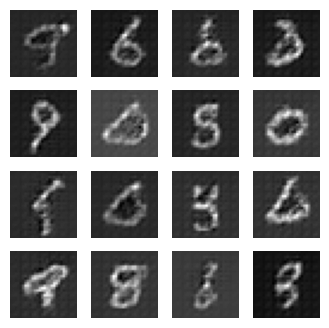

In [38]:
train(train_dataset, EPOCHS)

In [39]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

# Create GIF

In [40]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

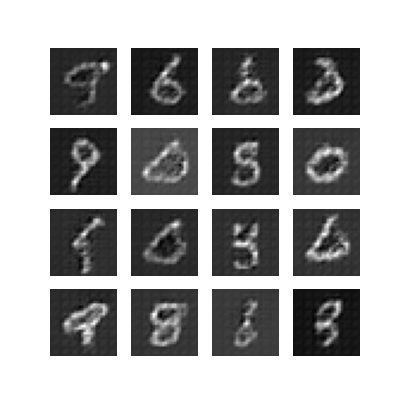

In [41]:
display_image(EPOCHS)

In [42]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-42-56bb6d34be2e>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-42-56bb6d34be2e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



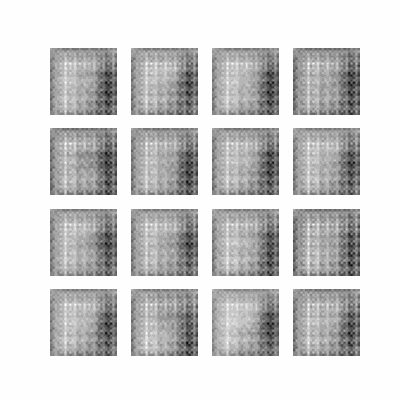

In [43]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)